## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split


import matplotlib.pyplot as plt

%matplotlib inline

### [MNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
* Handwritten digits with 10 classes
* the size of each image is 28x28 pixels 
* 50 000 data examples in training set, 10 000 examples in validation set, 10 000 in test set

In [2]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [3]:
print("The shape of the dataset is :", dataset.data.size())

The shape of the dataset is : torch.Size([60000, 28, 28])


In [0]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [50000, 10000])

Text(0.5, 1.0, 'image label: 0')

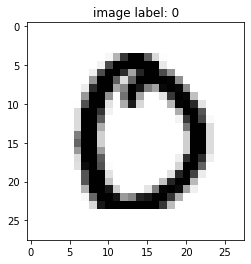

In [5]:
sample_index = 88

plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

### Training the neural network

In [0]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.l1 = nn.Linear(16*4*4, 32)
        self.l2 = nn.Linear(32, 10)# Input size is 28*28, output size should be the same with the number of classes
    def flatten(self, x):
        x = x.view(x.size()[0], -1)
        return x
    def forward(self, inputs):
        x = F.max_pool2d(F.relu(self.conv1(inputs)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2)) 
        x = F.relu(self.l1(self.flatten(x)))
        outputs = self.l2(x)
        
        return outputs

In [0]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 32

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()


# Optimizer
optimizer =torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images)  
            
            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [11]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/30], Loss: 0.3349
Epoch [2/30], Loss: 0.1074
Epoch [3/30], Loss: 0.0792
Epoch [4/30], Loss: 0.0657
Epoch [5/30], Loss: 0.0553
Epoch [6/30], Loss: 0.0489
Epoch [7/30], Loss: 0.0424
Epoch [8/30], Loss: 0.0387
Epoch [9/30], Loss: 0.0347
Epoch [10/30], Loss: 0.0306
Epoch [11/30], Loss: 0.0282
Epoch [12/30], Loss: 0.0250
Epoch [13/30], Loss: 0.0231
Epoch [14/30], Loss: 0.0215
Epoch [15/30], Loss: 0.0203
Epoch [16/30], Loss: 0.0167
Epoch [17/30], Loss: 0.0161
Epoch [18/30], Loss: 0.0166
Epoch [19/30], Loss: 0.0126
Epoch [20/30], Loss: 0.0140
Epoch [21/30], Loss: 0.0121
Epoch [22/30], Loss: 0.0110
Epoch [23/30], Loss: 0.0104
Epoch [24/30], Loss: 0.0103
Epoch [25/30], Loss: 0.0092
Epoch [26/30], Loss: 0.0092
Epoch [27/30], Loss: 0.0091
Epoch [28/30], Loss: 0.0075
Epoch [29/30], Loss: 0.0079
Epoch [30/30], Loss: 0.0076


Text(0.5, 1.0, 'Visualization of convergence')

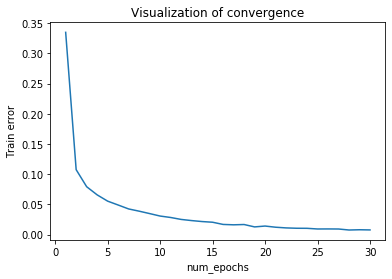

In [12]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [0]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [14]:
accuracy(val_set, model)

Accuracy of the model : 98.82 %


Text(0.5, 1.0, 'Prediction label: 2')

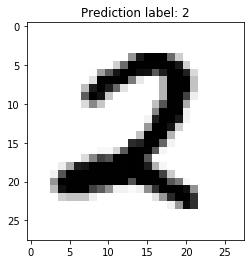

In [15]:
val_index = 14

(image, label) = val_set[val_index]
output = model(image.unsqueeze(0))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [0]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.MNIST(root='data/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [17]:
accuracy(test_set, model)

Accuracy of the model : 98.79 %
